## PDSPL Analysis
Author: Paras Sharma

We generate galaxy galaxy lenses population here.

In [1]:
# Standard imports
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


# Astropy imports
from astropy.io import fits
from astropy import units as u
from astropy.table import Table
from astropy.units import Quantity
from astropy import constants as const
import corner

# SLSim imports
import slsim.Pipelines as pipelines
import slsim.Sources as sources
import slsim.Deflectors as deflectors
from slsim.Lenses.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
from slsim.Lenses.lens import Lens
from slsim.LOS.los_pop import LOSPop

# Lenstronomy, HierArc imports
from lenstronomy.LensModel.lens_model import LensModel
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam

# set global plotting parameters for academic paper
# plt.rcParams.update({
#     "font.size": 12,
#     "axes.labelsize": 14,
#     "axes.titlesize": 14,
#     "xtick.labelsize": 12,
#     "ytick.labelsize": 12,
#     "legend.fontsize": 12,
#     "figure.titlesize": 16,
#     "figure.figsize": (8, 6),
#     "lines.linewidth": 1.5,
#     "lines.markersize": 6,
#     "font.family": "serif",
#     "text.usetex": True,
# })

/Users/paras/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/paras/Projects/repos/self/slsim/slsim/Plots/lens_plots.py:5: UserWarning: If you want to simulate images with Roman filters, please install the galsim module.
Note that this module is not supported on Windows
  from slsim.ImageSimulation.roman_image_simulation import simulate_roman_image


## Generate SLSim Catalog

In [2]:
# define a cosmology
cosmology = "FwCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
kwargs_cosmo_true = {"h0": 70, "om": 0.3, "w": -1}  # cosmological model of the forecast

# create astropy.cosmology instance of input cosmology
cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

# define a sky area
sky_area_galaxies = Quantity(value=10, unit="deg2")

# Generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None, sky_area=sky_area_galaxies, filters=None, cosmo=cosmo_true
)

In [3]:
# define a sky area
sky_area_source = Quantity(value=10, unit="deg2")  # sky area of the source population
sky_area_deflector = Quantity(value=10, unit="deg2")  # sky area of the deflector population
sky_area_lens = Quantity(value=5000, unit="deg2")  # sky area of the lens population


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

# Initiate deflector population class.
# lens_galaxies = deflectors.AllLensGalaxies(
#     red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
#     blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
#     kwargs_cut=kwargs_deflector_cut,
#     kwargs_mass2light=None,
#     cosmo=cosmo_true,
#     sky_area=sky_area_deflector,
# )
lens_galaxies = deflectors.EllipticalLensGalaxies(
    galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light=None,
    cosmo=cosmo_true,
    sky_area=sky_area_deflector,
    # gamma_pl=2.1, by default it is set to 2.0
)

# Initiate source population class.
source_galaxies = sources.Galaxies(
    galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_source_cut,
    cosmo=cosmo_true,
    sky_area=sky_area_source,
    catalog_type="skypy",
)

# make galaxy-galaxy population class using LensPop
gg_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_galaxies,
    cosmo=cosmo_true,
    sky_area=sky_area_lens,
    los_pop=LOSPop(los_bool=False),  # no line-of-sight population
)

# make lensplot class for extracting rgb images
gg_plot = LensingPlots(gg_lens_pop, num_pix=100, coadd_years=10)

print(f"LensPop initialized. Potential deflectors: {gg_lens_pop.deflector_number} ; Potential sources: {gg_lens_pop.source_number}");

/Users/paras/Projects/repos/self/slsim/slsim/Deflectors/DeflectorPopulation/elliptical_lens_galaxies.py:48: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  galaxy_list = param_util.catalog_with_angular_size_in_arcsec(


LensPop initialized. Potential deflectors: 126209500 ; Potential sources: 2372885500


In [4]:
kwargs_lens_cut = {"min_image_separation": 1, "max_image_separation": 10}
# kwargs_lens_cut = {}
selected_lenses = gg_lens_pop.draw_population(
    kwargs_lens_cuts=kwargs_lens_cut,
)

# selected_lenses = []
# num_lenses = 5000  # Number of lenses to select

# for i in tqdm(range(num_lenses)):
#     try:
#         selected_lenses.append(
#         gg_lens_pop.select_lens_at_random()
#     )
#     except Exception as e:
#         print(f"Error drawing lens {i}: {e}")


# Print the number of selected lenses
print(f"Number of selected lenses: {len(selected_lenses)}")

Drawing lens population: 100%|██████████| 126209500/126209500 [2:02:44<00:00, 17138.41it/s] 

Number of selected lenses: 526339


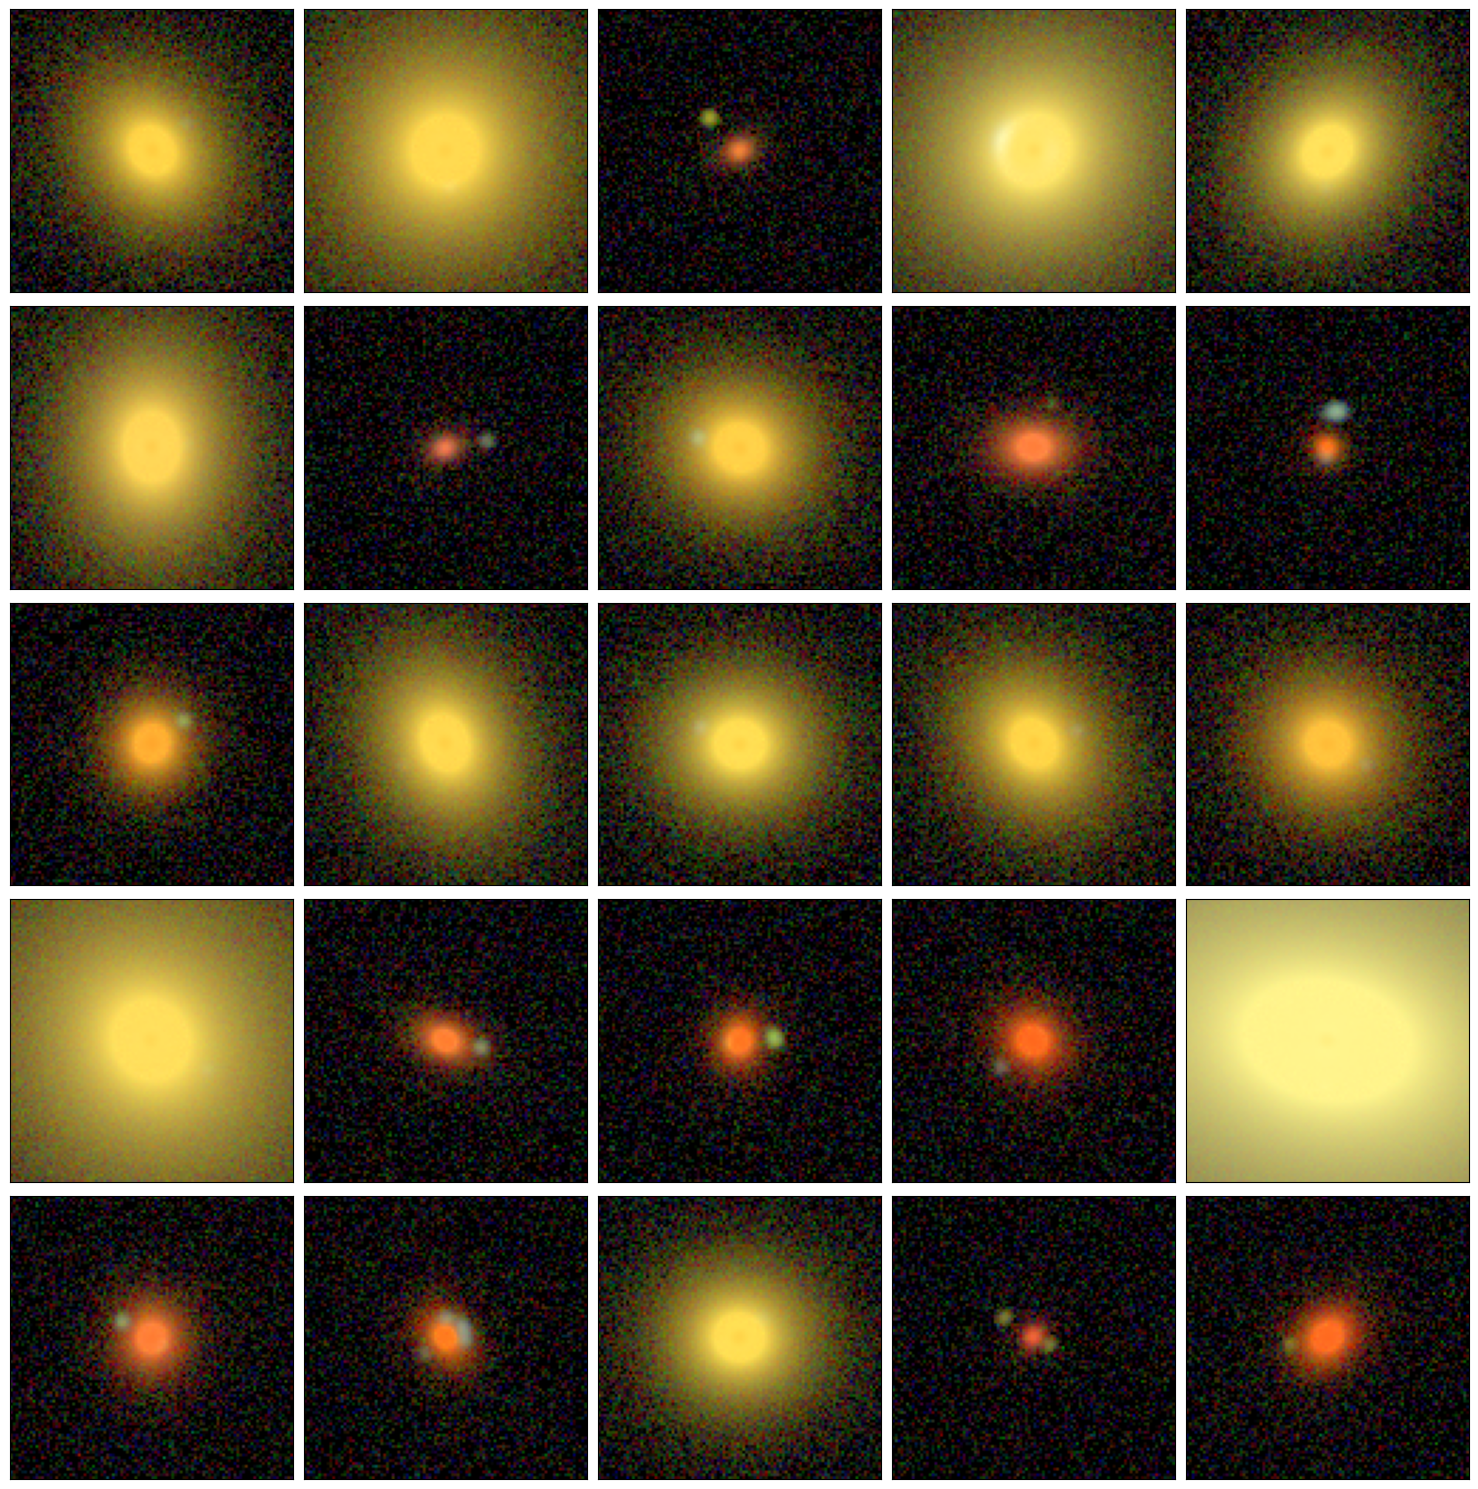

In [5]:
kwargs_lens_cut = {"min_image_separation": 3, "max_image_separation": 10}
gg_plot.plot_montage(rgb_band_list=["i", "r", "g"], 
                     n_horizont= 5,
                     n_vertical= 5,
                     kwargs_lens_cut=kwargs_lens_cut,
                    #  add_noise=False,
                     );

In [6]:
%%writefile lens_worker.py
# This entire cell will be saved as 'lens_worker.py'

import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.LensModel.lens_model import LensModel

cosmo_true = FlatLambdaCDM(H0=70, Om0=0.3)

# --- THE WORKER FUNCTION ---
def extract_lens_properties(args):
    """
    Worker function that takes a tuple (id, lens_object), extracts all
    properties, and returns them as a single dictionary.
    """
    lens_id, lens = args
    
    try:
        source = lens.source(index=0)
        deflector = lens.deflector

        z_D = lens.deflector_redshift
        z_S = source.redshift
        theta_E = lens.einstein_radius[0]
        sigma_v_D = deflector.velocity_dispersion()
        e1_mass_D, e2_mass_D = deflector.mass_ellipticity
        
        half_light_radii_arcsec = deflector.angular_size_light
        
        lenstronomy_kwargs = lens.lenstronomy_kwargs()
        lens_model_lenstronomy = LensModel(lens_model_list=lenstronomy_kwargs[0]["lens_model_list"])
        lenstronomy_kwargs_lens = lenstronomy_kwargs[1]["kwargs_lens"]
        
        deflector_center = deflector.deflector_center
        grid = np.linspace(-half_light_radii_arcsec, half_light_radii_arcsec, 500)
        xs, ys = np.meshgrid(grid + deflector_center[0], grid + deflector_center[1])
        
        kappa_map = lens_model_lenstronomy.kappa(xs, ys, kwargs=lenstronomy_kwargs_lens)
        mask = np.sqrt((xs - deflector_center[0])**2 + (ys - deflector_center[1])**2) < half_light_radii_arcsec / 2
        kappa_within_half_light_radii = np.nanmean(kappa_map[mask])

        D_s = cosmo_true.angular_diameter_distance(lens.source_redshift_list[0])
        D_d = cosmo_true.angular_diameter_distance(lens.deflector_redshift)
        D_ds = cosmo_true.angular_diameter_distance_z1z2(lens.deflector_redshift, lens.source_redshift_list[0])
        
        sigma_crit = (const.c**2 / (4 * np.pi * const.G)) * (D_s / (D_d * D_ds))
        sigma_crit = sigma_crit.to(u.Msun / u.pc**2).value
        surface_density = sigma_crit * kappa_within_half_light_radii

        surface_brightness_map = deflector.surface_brightness(xs, ys, band="g")
        mask_sb = np.sqrt((xs - deflector_center[0])**2 + (ys - deflector_center[1])**2) < half_light_radii_arcsec
        mean_surface_brightness = np.nanmean(surface_brightness_map[mask_sb])

        R_e_kpc_val = (cosmo_true.kpc_proper_per_arcmin(lens.deflector_redshift) * \
                      ((half_light_radii_arcsec * u.arcsec).to(u.arcmin))).to(u.kpc).value

        return {
            "lens_id": lens_id, "z_D": z_D, "z_S": z_S, "theta_E": theta_E, "sigma_v_D": sigma_v_D,
            "stellar_mass_D": deflector.stellar_mass, "mag_S_i": source.extended_source_magnitude("i"),
            "mag_S_r": source.extended_source_magnitude("r"), "mag_S_g": source.extended_source_magnitude("g"),
            "mag_S_z": source.extended_source_magnitude("z"), "mag_S_y": source.extended_source_magnitude("y"),
            "mag_D_i": deflector.magnitude("i"), "mag_D_r": deflector.magnitude("r"), "mag_D_g": deflector.magnitude("g"),
            "mag_D_z": deflector.magnitude("z"), "mag_D_y": deflector.magnitude("y"), "size_D": deflector.angular_size_light,
            "e1_mass_D": e1_mass_D, "e2_mass_D": e2_mass_D, "e_mass_D": np.sqrt(e1_mass_D**2 + e2_mass_D**2),
            "gamma_pl": deflector.halo_properties['gamma_pl'], "R_e_kpc": R_e_kpc_val,
            "Sigma_half_Msun/pc2": surface_density, "surf_bri_mag/arcsec2": mean_surface_brightness,
        }
    except Exception as e:
        print(f"Error processing lens ID {lens_id}: {e}")
        return None

Overwriting lens_worker.py


In [7]:
import multiprocessing
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u

# --- Import the worker function from the file we just created ---
from lens_worker import extract_lens_properties


# 2. RUN IN PARALLEL
num_processes = multiprocessing.cpu_count()
print(f"Starting parallel processing with {num_processes} cores...")

with multiprocessing.Pool(processes=num_processes) as pool:
    # Use enumerate() to pass both the ID and the lens object to the worker
    results_list = list(tqdm(
        pool.imap(extract_lens_properties, enumerate(selected_lenses)),
        total=len(selected_lenses),
        desc="Calculating lens properties"
    ))

# 3. PROCESS RESULTS
results_list = [res for res in results_list if res is not None]

if results_list:
    df = pd.DataFrame(results_list)
    final_table = Table.from_pandas(df)
    
    # Save the table to a FITS file
    output_path = f"../data/GGL_{sky_area_lens.value}_SQDEG.fits"
    final_table.write(output_path, format="fits", overwrite=True)
    
    print("\nProcessing complete. First 5 rows of the generated table:")
    print(final_table[:5])
else:
    print("No results were generated.")

Starting parallel processing with 11 cores...


Calculating lens properties: 100%|██████████| 526339/526339 [1:04:57<00:00, 135.06it/s]



Processing complete. First 5 rows of the generated table:
lens_id         z_D         ... Sigma_half_Msun/pc2 surf_bri_mag/arcsec2
------- ------------------- ... ------------------- --------------------
      0 0.18128125534860448 ...   6179.011740633373   21.353620549667575
      1  1.6461110256264142 ...   5102.452953253668    25.81182776257157
      2  0.7018574780219449 ...  3316.9959496287297    24.61678400482324
      3  0.3771217828927475 ...  6481.7737097569425   22.756939185989026
      4  0.4992084355727959 ...   3196.018497061882     24.0606715980108


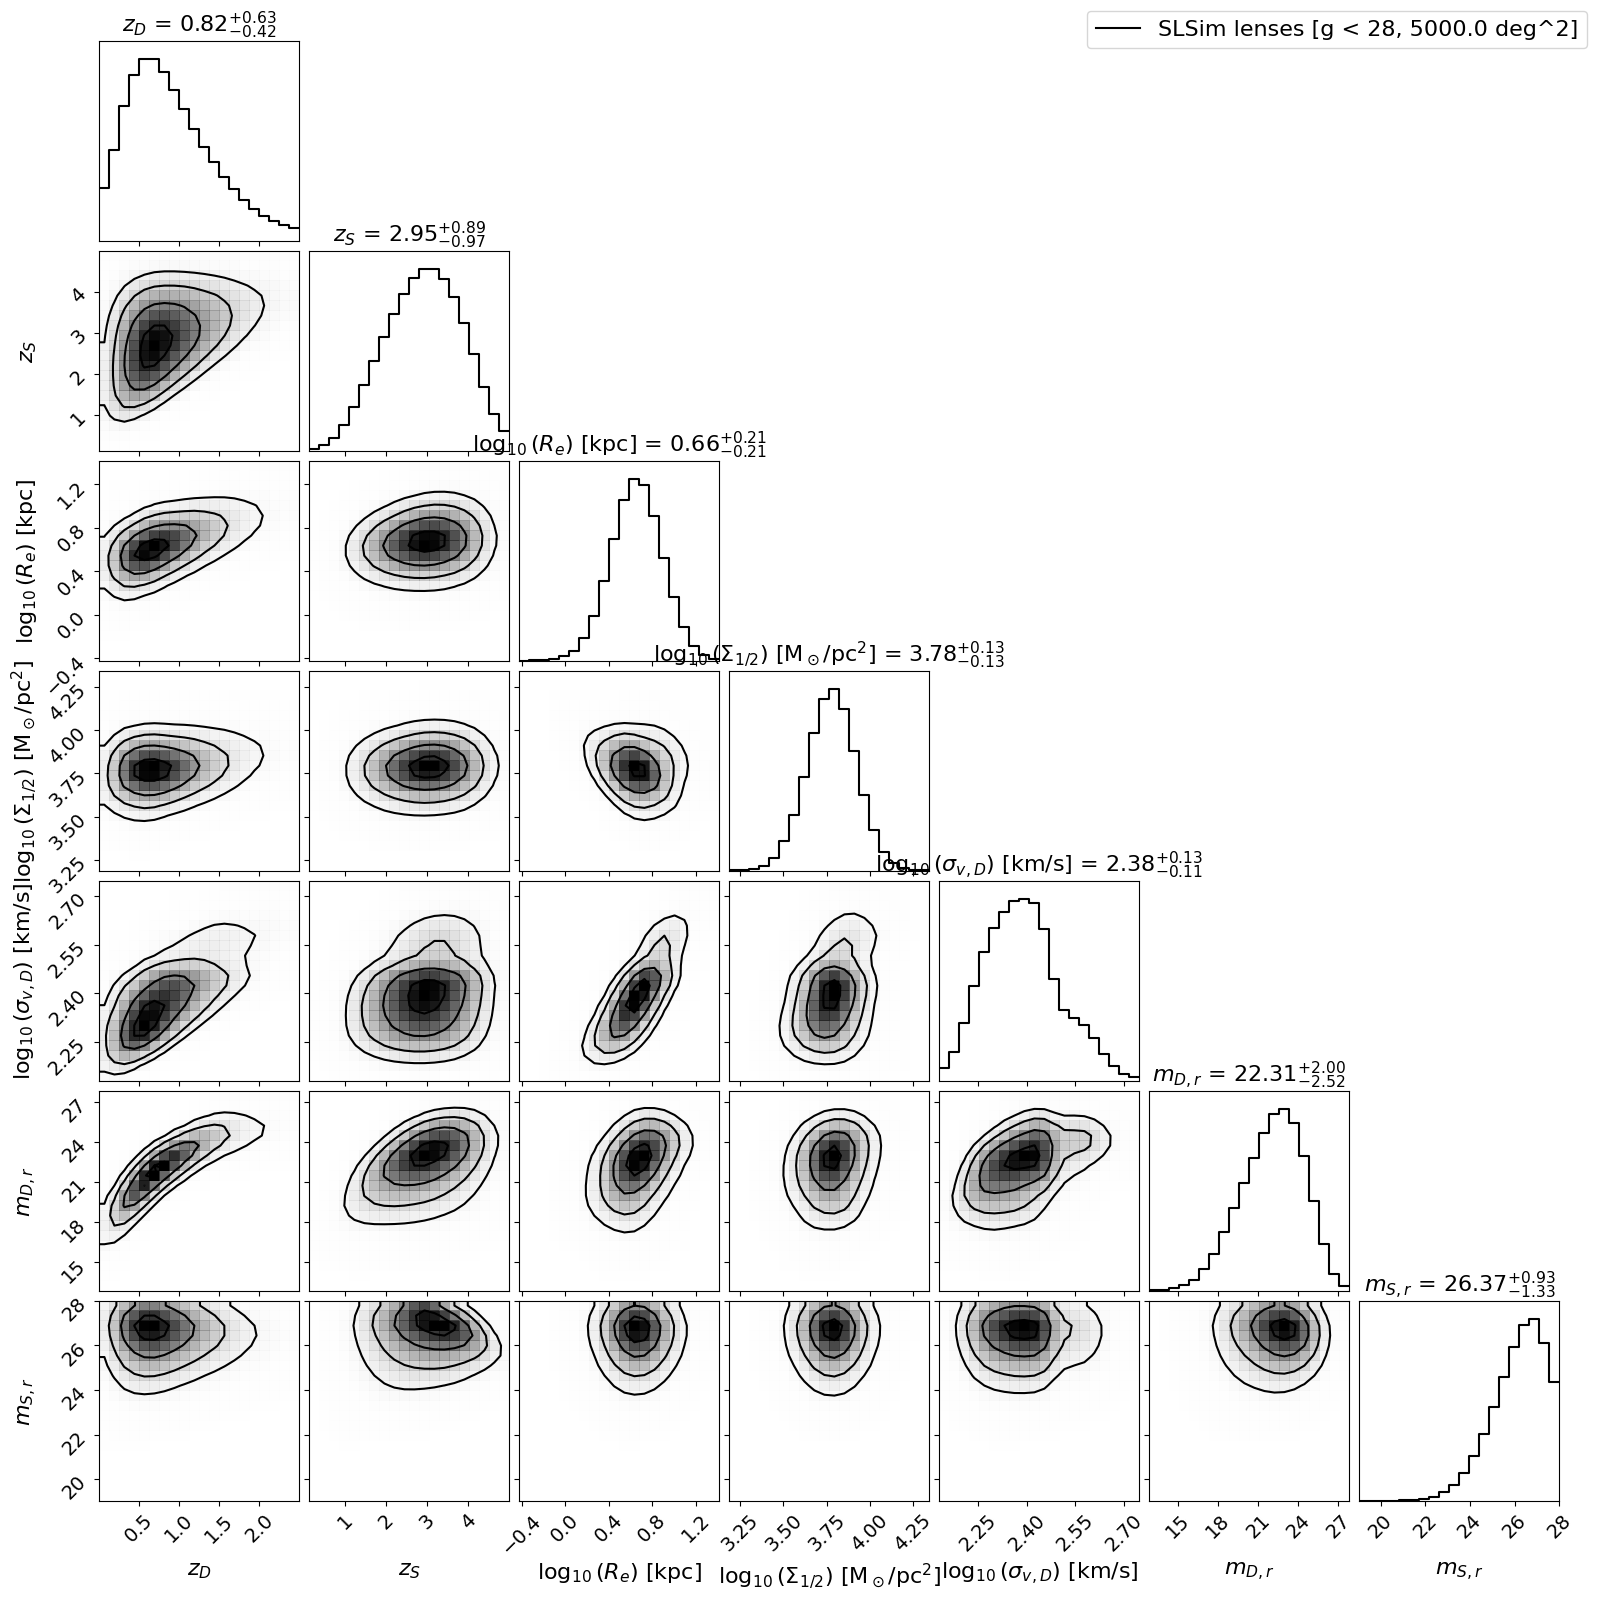

In [8]:
GGL_data_table = Table.read(f"../data/GGL_{sky_area_lens.value}_SQDEG.fits", format='fits')

#### Make corner plot of the Original and 3 depth cut data sets
key_list = ['z_D',
            'z_S',
            'log_R_e_kpc', 
            'log_Sigma_half_Msun/pc2', 
            'log_sigma_v_D', 
            'mag_D_r', 
            'mag_S_r']
key_latex_labels = {
    'z_D': r'$z_D$',
    'z_S': r'$z_S$',
    'log_R_e_kpc': r'$\log_{10}(R_e)$ [kpc]',
    'log_Sigma_half_Msun/pc2': r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$/pc$^2$]',
    'log_sigma_v_D': r'$\log_{10}(\sigma_{v, D})$ [km/s]',
    'mag_D_r': r'$m_{D, r}$',
    'mag_S_r': r'$m_{S, r}$'
}

GGL_data_table['log_R_e_kpc'] = np.log10(GGL_data_table['R_e_kpc'])
GGL_data_table['log_Sigma_half_Msun/pc2'] = np.log10(GGL_data_table['Sigma_half_Msun/pc2'])
GGL_data_table['log_sigma_v_D'] = np.log10(GGL_data_table['sigma_v_D'])

data_corner = [GGL_data_table[key] for key in key_list]
data_corner = np.array(data_corner).T


fig_corner = corner.corner(
    data_corner,
    labels=[key_latex_labels[key] for key in key_list],
    show_titles=True,
    smooth=True,
    smooth1d=True,
    plot_datapoints=False,
);


fig_corner.legend(
    [f'SLSim lenses [g < 28, {sky_area_lens.value} deg^2]'],
    loc='upper right',
    fontsize=16
)

# make the font size of the labels and titles larger
for ax in fig_corner.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.set_title(ax.get_title(), fontsize=16)

deflector_center: [0.05269091 0.00888121]


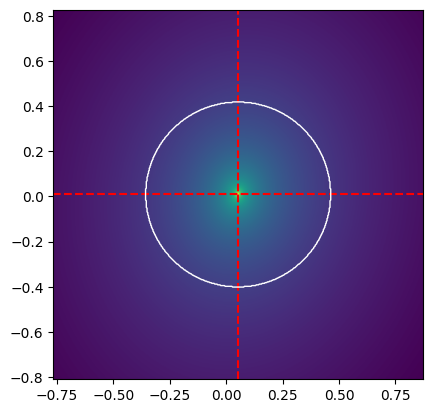

In [9]:
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.LensModel.lens_model import LensModel

cosmo_true = FlatLambdaCDM(H0=70, Om0=0.3)

lens = selected_lenses[1000]


source = lens.source(index=0)
deflector = lens.deflector

z_D = lens.deflector_redshift
z_S = source.redshift
theta_E = lens.einstein_radius[0]
sigma_v_D = deflector.velocity_dispersion()
e1_mass_D, e2_mass_D = deflector.mass_ellipticity

half_light_radii_arcsec = deflector.angular_size_light

lenstronomy_kwargs = lens.lenstronomy_kwargs()
lens_model_lenstronomy = LensModel(lens_model_list=lenstronomy_kwargs[0]["lens_model_list"])
lenstronomy_kwargs_lens = lenstronomy_kwargs[1]["kwargs_lens"]

deflector_center = deflector.deflector_center
grid = np.linspace(-half_light_radii_arcsec, half_light_radii_arcsec, 500)
xs, ys = np.meshgrid(grid + deflector_center[0], grid + deflector_center[1])
print("deflector_center:", deflector_center)

kappa_map = lens_model_lenstronomy.kappa(xs, ys, kwargs=lenstronomy_kwargs_lens)
mask = np.sqrt((xs - deflector_center[0])**2 + (ys - deflector_center[1])**2) < half_light_radii_arcsec / 2
kappa_within_half_light_radii = np.nanmean(kappa_map[mask])

D_s = cosmo_true.angular_diameter_distance(lens.source_redshift_list[0])
D_d = cosmo_true.angular_diameter_distance(lens.deflector_redshift)
D_ds = cosmo_true.angular_diameter_distance_z1z2(lens.deflector_redshift, lens.source_redshift_list[0])

sigma_crit = (const.c**2 / (4 * np.pi * const.G)) * (D_s / (D_d * D_ds))
sigma_crit = sigma_crit.to(u.Msun / u.pc**2).value
surface_density = sigma_crit * kappa_within_half_light_radii

surface_brightness_map = deflector.surface_brightness(xs, ys, band="g")
mask_sb = np.sqrt((xs - deflector_center[0])**2 + (ys - deflector_center[1])**2) < half_light_radii_arcsec
mean_surface_brightness = np.nanmean(surface_brightness_map[mask_sb])

R_e_kpc_val = (cosmo_true.kpc_proper_per_arcmin(lens.deflector_redshift) * \
                ((half_light_radii_arcsec * u.arcsec).to(u.arcmin))).to(u.kpc).value



plt.figure()
plt.imshow(np.log10(kappa_map), extent=[xs[0,0], xs[0,-1], ys[0,0], ys[-1,0]], origin='lower')
plt.axvline(deflector_center[0], color='r', linestyle='--')
plt.axhline(deflector_center[1], color='r', linestyle='--')

# mask border
plt.contour(mask, levels=[0.5], colors='white', linewidths=1, extent=[xs[0,0], xs[0,-1], ys[0,0], ys[-1,0]])